In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Constants
MAX_LINES = 5
MAX_BET = 100
MIN_BET = 1

ROWS = 3
COLS = 3

# Symbol definitions with probabilities and values
symbols = {
    "A": {"count": 1, "value": 20},
    "B": {"count": 3, "value": 15},
    "C": {"count": 5, "value": 10},
    "D": {"count": 7, "value": 8},
    "E": {"count": 9, "value": 5}
}

# Multiplier definitions
multipliers = {
    "A": 3,
    "B": 2.5,
    "C": 2,
    "D": 1.5,
    "E": 1.2
}

# Define custom lines
lines = [
    [(0, 0), (1, 0), (2, 0)],  # Top row
    [(0, 1), (1, 1), (2, 1)],  # Middle row
    [(0, 2), (1, 2), (2, 2)],  # Bottom row
    [(0, 0), (1, 1), (2, 2)],  # Top-left to bottom-right diagonal
    [(2, 0), (1, 1), (0, 2)]   # Bottom-left to top-right diagonal
]

def check_winnings_custom(columns, lines, bet, values, multipliers):
    winnings = 0
    for line in lines:
        symbol = columns[line[0][0]][line[0][1]]
        for position in line:
            if symbol != columns[position[0]][position[1]]:
                break
        else:
            winnings += values[symbol] * bet * multipliers[symbol]
    return winnings

def get_slot_machine_spin(rows, cols, symbols):
    all_symbols = []
    for symbol, symbol_info in symbols.items():
        for _ in range(symbol_info["count"]):
            all_symbols.append(symbol)

    columns = []
    for _ in range(cols):
        column = []
        current_symbols = all_symbols[:]
        for _ in range(rows):
            value = random.choice(current_symbols)
            current_symbols.remove(value)
            column.append(value)
        columns.append(column)

    return columns


C:\Users\User\AppData\Local\Temp\ipykernel_7804\1789829286.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  states = torch.FloatTensor(states)


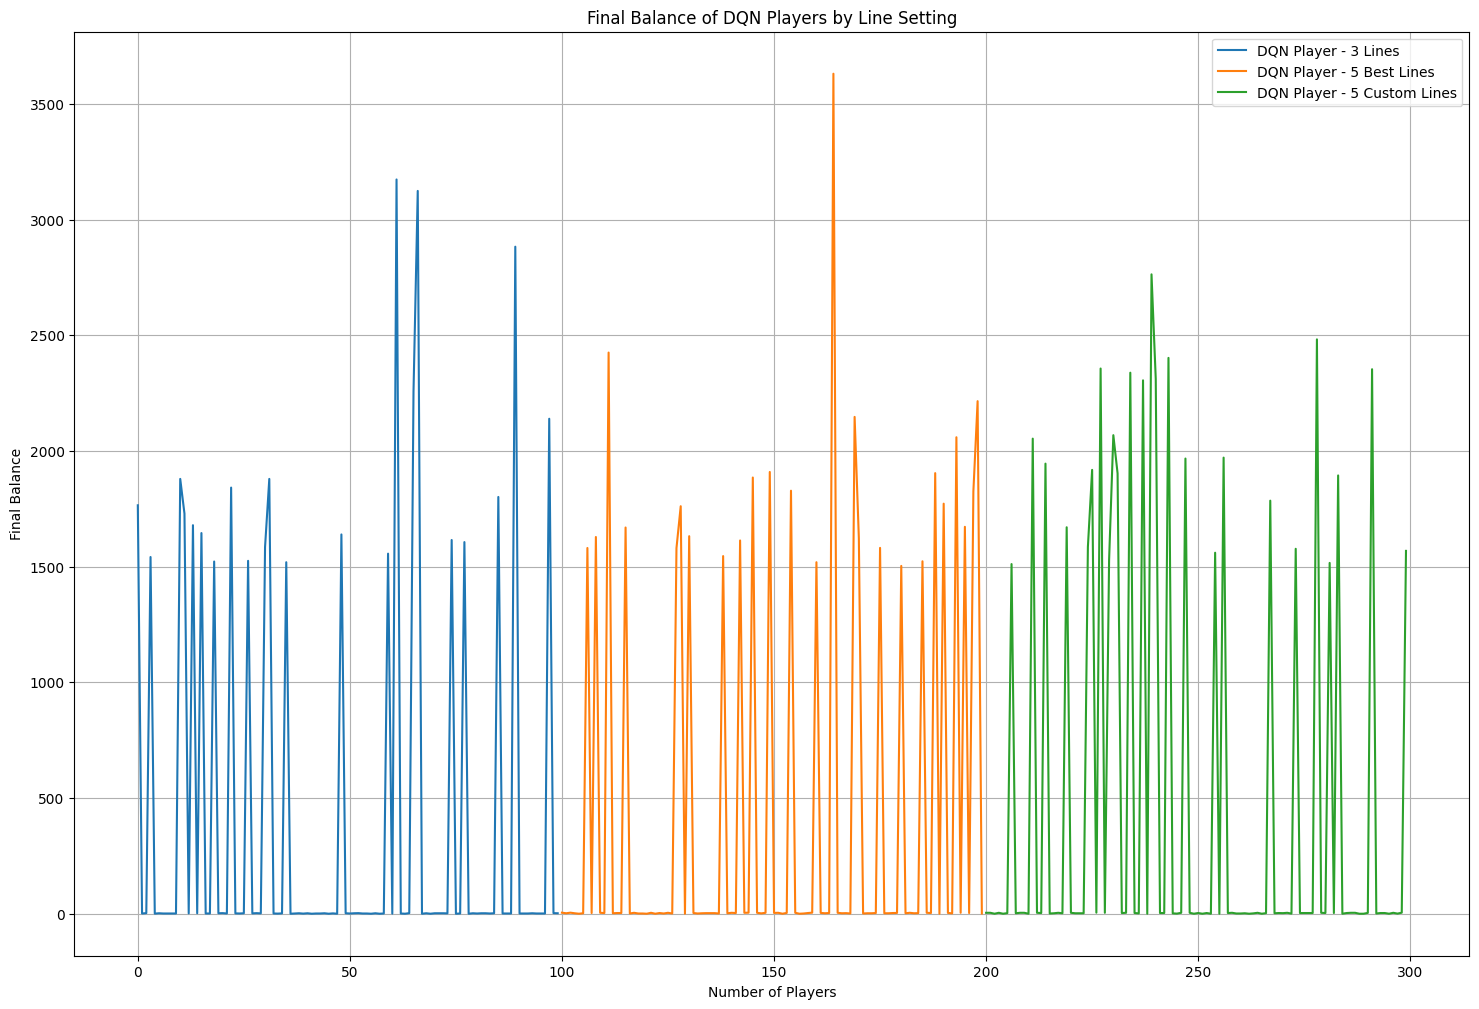

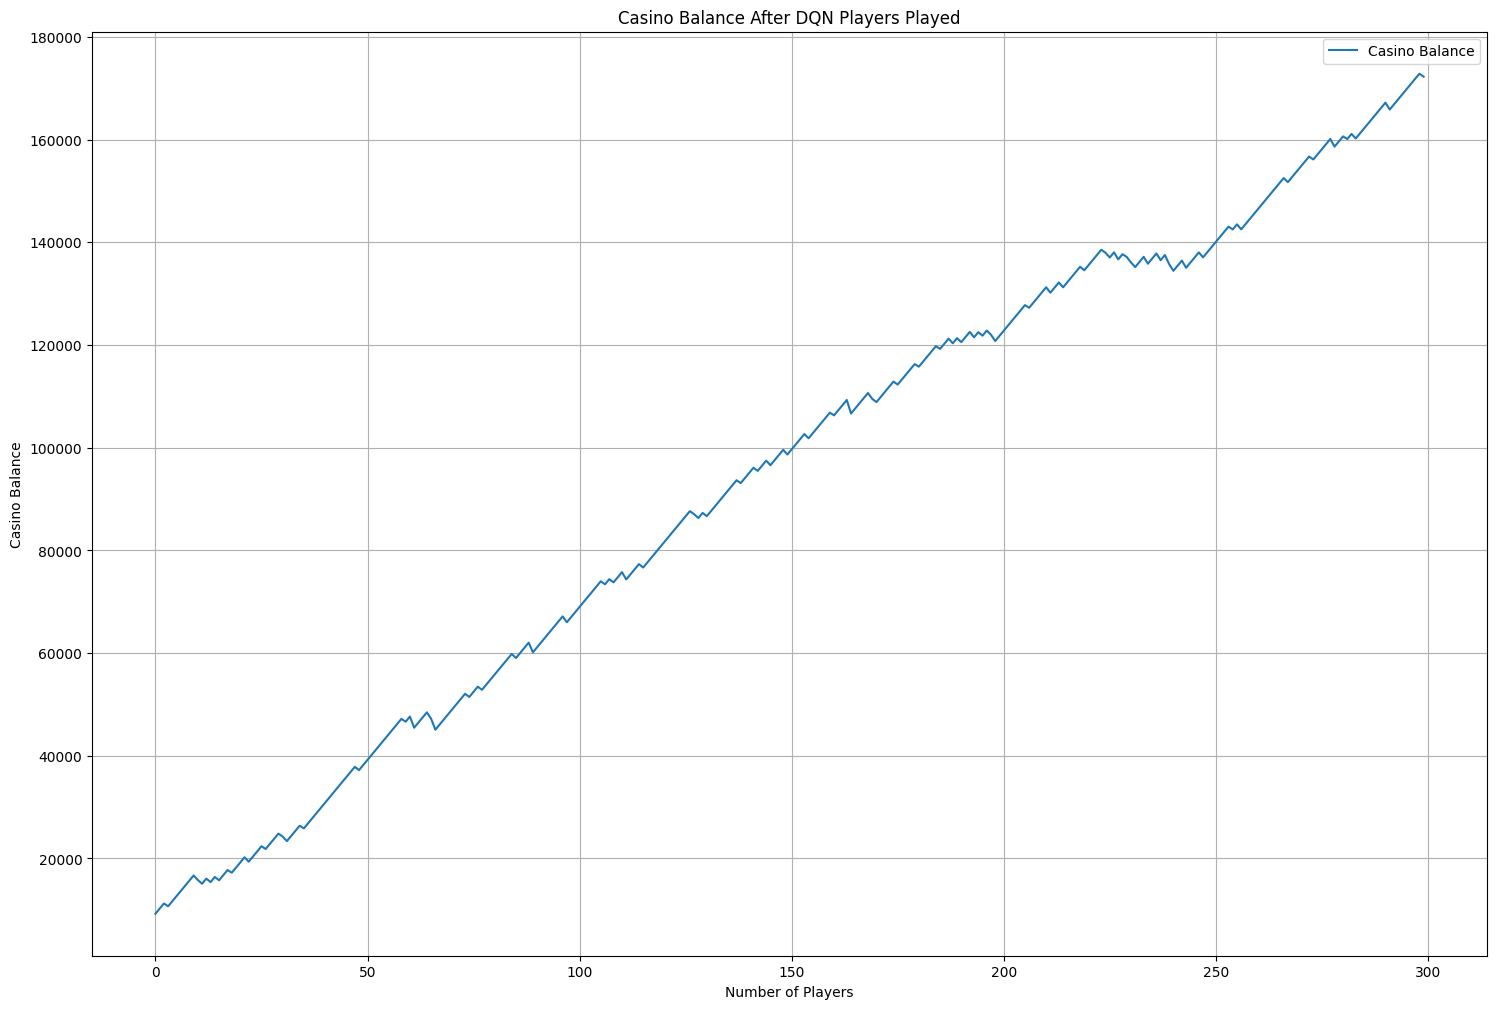

,lines,final_balance,casino_balance
0,3 Lines,1765.0,9235.0
1,3 Lines,1.0,10234.0
2,3 Lines,2.5,11231.5
3,3 Lines,1541.5,10690.0
4,3 Lines,0.5,11689.5
...,...,...,...
295,5 Custom Lines,0.0,169859.0
296,5 Custom Lines,4.0,170855.0
297,5 Custom Lines,0.5,171854.5
298,5 Custom Lines,4.5,172850.0


In [2]:
# Parameters for DQN
num_spins_dqn = 1000
initial_balance_dqn = 1000
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
alpha = 0.001  # Learning rate
gamma = 0.9  # Discount factor
batch_size = 64
memory_size = 10000

# Define the state and action space
state_space = 4  # balance, bet, win_streak, loss_streak
action_space = 3  # cautious, aggressive, random

# Neural network model
class DQN(nn.Module):
    def __init__(self, state_space, action_space):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_space, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_space)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Initialize DQN, loss function, and optimizer
model = DQN(state_space, action_space)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=alpha)

# Experience replay memory
memory = deque(maxlen=memory_size)

def get_state(balance, bet, win_streak, loss_streak):
    return np.array([balance, bet, win_streak, loss_streak])

def choose_action(state, epsilon):
    if np.random.rand() < epsilon:
        return random.choice([0, 1, 2])
    else:
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            return model(state).argmax().item()

def update_memory(state, action, reward, next_state, done):
    memory.append((state, action, reward, next_state, done))

def replay():
    if len(memory) < batch_size:
        return
    
    mini_batch = random.sample(memory, batch_size)
    states, actions, rewards, next_states, dones = zip(*mini_batch)

    states = torch.FloatTensor(states)
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards)
    next_states = torch.FloatTensor(next_states)
    dones = torch.FloatTensor(dones)

    q_values = model(states).gather(1, actions).squeeze()
    next_q_values = model(next_states).max(1)[0]
    target_q_values = rewards + (gamma * next_q_values * (1 - dones))

    loss = criterion(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def simulate_dqn_player(start_balance, num_spins, lines_to_bet):
    balance = start_balance
    balances = []
    win_streak = 0
    loss_streak = 0
    epsilon = epsilon_start
    for i in range(num_spins):
        balances.append(balance)
        state = get_state(balance, max(MIN_BET, min(int(balance * 0.01), MAX_BET)), win_streak, loss_streak)
        action = choose_action(state, epsilon)
        
        if action == 0:
            bet = max(MIN_BET, min(int(balance * 0.01), MAX_BET))
        elif action == 1:
            bet = min(int(balance * 0.02), MAX_BET)
        else:
            bet = max(MIN_BET, min(int(balance * random.uniform(0.01, 0.1)), MAX_BET))
        
        total_bet = bet * len(lines_to_bet)
        if total_bet > balance:
            continue

        slots = get_slot_machine_spin(ROWS, COLS, symbols)
        winnings = check_winnings_custom(slots, lines_to_bet, bet, {k: v["value"] for k, v in symbols.items()}, multipliers)
        next_balance = balance + winnings - total_bet
        reward = next_balance - balance
        next_state = get_state(next_balance, bet, win_streak if winnings > 0 else 0, loss_streak + 1 if winnings == 0 else 0)
        done = next_balance <= 0
        
        update_memory(state, action, reward, next_state, done)
        replay()
        
        balance = next_balance
        if winnings > 0:
            win_streak += 1
            loss_streak = 0
        else:
            loss_streak += 1
            win_streak = 0
        
        if done or balance >= start_balance * 1.5:
            break
        
        epsilon = max(epsilon_end, epsilon_decay * epsilon)

    return balances, balance

# Simulation parameters
num_spins_dqn = 1000
initial_balance_dqn = 1000
casino_initial_balance_dqn = 10000
num_players_dqn = 100

# Line settings
three_lines = lines[:3]
five_lines_best = lines
five_lines_custom = random.sample(lines, 3) + random.sample(lines, 2)

# Initialize casino balance
casino_balance_dqn = casino_initial_balance_dqn

# Simulate DQN players
results_dqn = {
    "lines": [],
    "final_balance": [],
    "casino_balance": []
}

for line_setting, line_desc in [(three_lines, "3 Lines"), (five_lines_best, "5 Best Lines"), (five_lines_custom, "5 Custom Lines")]:
    for _ in range(num_players_dqn):
        balances, final_balance = simulate_dqn_player(initial_balance_dqn, num_spins_dqn, line_setting)
        casino_balance_dqn += (initial_balance_dqn - final_balance)
        results_dqn["lines"].append(line_desc)
        results_dqn["final_balance"].append(final_balance)
        results_dqn["casino_balance"].append(casino_balance_dqn)

# Convert results to DataFrame
df_results_dqn = pd.DataFrame(results_dqn)

# Plot results
plt.figure(figsize=(18, 12))

# Plot player balances
for line_desc, group in df_results_dqn.groupby("lines"):
    plt.plot(group.index, group["final_balance"], label=f"DQN Player - {line_desc}")

plt.xlabel("Number of Players")
plt.ylabel("Final Balance")
plt.title("Final Balance of DQN Players by Line Setting")
plt.legend()
plt.grid(True)
plt.show()

# Plot casino balance
plt.figure(figsize=(18, 12))
plt.plot(df_results_dqn["casino_balance"], label="Casino Balance")
plt.xlabel("Number of Players")
plt.ylabel("Casino Balance")
plt.title("Casino Balance After DQN Players Played")
plt.legend()
plt.grid(True)
plt.show()
df_results_dqn

In [5]:
df_results_dqn.to_csv()

',lines,final_balance,casino_balance\r\n0,3 Lines,1765.0,9235.0\r\n1,3 Lines,1.0,10234.0\r\n2,3 Lines,2.5,11231.5\r\n3,3 Lines,1541.5,10690.0\r\n4,3 Lines,0.5,11689.5\r\n5,3 Lines,2.0,12687.5\r\n6,3 Lines,1.0,13686.5\r\n7,3 Lines,1.0,14685.5\r\n8,3 Lines,1.0,15684.5\r\n9,3 Lines,1.0,16683.5\r\n10,3 Lines,1879.0,15804.5\r\n11,3 Lines,1729.0,15075.5\r\n12,3 Lines,1.5,16074.0\r\n13,3 Lines,1679.0,15395.0\r\n14,3 Lines,2.0,16393.0\r\n15,3 Lines,1645.0,15748.0\r\n16,3 Lines,1.0,16747.0\r\n17,3 Lines,1.0,17746.0\r\n18,3 Lines,1522.0,17224.0\r\n19,3 Lines,2.0,18222.0\r\n20,3 Lines,2.5,19219.5\r\n21,3 Lines,1.0,20218.5\r\n22,3 Lines,1841.5,19377.0\r\n23,3 Lines,1.5,20375.5\r\n24,3 Lines,1.0,21374.5\r\n25,3 Lines,2.0,22372.5\r\n26,3 Lines,1525.0,21847.5\r\n27,3 Lines,1.5,22846.0\r\n28,3 Lines,2.5,23843.5\r\n29,3 Lines,1.5,24842.0\r\n30,3 Lines,1585.0,24257.0\r\n31,3 Lines,1879.0,23378.0\r\n32,3 Lines,1.0,24377.0\r\n33,3 Lines,0.5,25376.5\r\n34,3 Lines,1.5,26375.0\r\n35,3 Lines,1519.0,25856.0\r\